# 1. Data preprocessing
## import lib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

## 1) load data and remove duplicated data


In [66]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')

In [67]:
data.head

<bound method NDFrame.head of           Sentence #           Word  POS Tag
0        Sentence: 1      Thousands  NNS   O
1                NaN             of   IN   O
2                NaN  demonstrators  NNS   O
3                NaN           have  VBP   O
4                NaN        marched  VBN   O
...              ...            ...  ...  ..
1048570          NaN           they  PRP   O
1048571          NaN      responded  VBD   O
1048572          NaN             to   TO   O
1048573          NaN            the   DT   O
1048574          NaN         attack   NN   O

[1048575 rows x 4 columns]>

In [68]:
print(f' # of rows : {len(data)}')
print(f' null in datas : {data.isnull().values.any()}')

 # of rows : 1048575
 null in datas : True


In [69]:
print(f'# null in data')
print('-'*20)
print(data.isnull().sum())

# null in data
--------------------
Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64


In [70]:
print(f'rm duplicated data[\'sencence\'] : {data["Sentence #"].nunique()}')
print(f'rm duplicated data[\'Word\'] : {data.Word.nunique()}')
print(f'rm duplicated data[\'Tag\'] : {data.Tag.nunique()}')

rm duplicated data['sencence'] : 47959
rm duplicated data['Word'] : 35178
rm duplicated data['Tag'] : 17


BIO 표현 방법에서 아무런 태깅도 의미하지 않는 O가 가장 887,908개로 가장 많은 개수를 차지함을 볼 수 있습니다.

In [71]:
print('Tag count table')
print('-'*20)
print(data.groupby('Tag').size().reset_index(name='count'))
# groupby object unpacking
#for i in data.groupby('Tag'):
#  print(i)

Tag count table
--------------------
      Tag   count
0   B-art     402
1   B-eve     308
2   B-geo   37644
3   B-gpe   15870
4   B-nat     201
5   B-org   20143
6   B-per   16990
7   B-tim   20333
8   I-art     297
9   I-eve     253
10  I-geo    7414
11  I-gpe     198
12  I-nat      51
13  I-org   16784
14  I-per   17251
15  I-tim    6528
16      O  887908


- fillna(method='ffill')을 활용하여 null 값을 가진 바로 이전행의 값으로 초기화
  * ffill : front fill로 추정

In [72]:
data = data.fillna(method='ffill')
print(data[-5:-1])
print(data.isnull().any())

              Sentence #       Word  POS Tag
1048570  Sentence: 47959       they  PRP   O
1048571  Sentence: 47959  responded  VBD   O
1048572  Sentence: 47959         to   TO   O
1048573  Sentence: 47959        the   DT   O
Sentence #    False
Word          False
POS           False
Tag           False
dtype: bool


- 대문자->소문자(문자의 갯수를 줄이기 위함, 어차피 같은 뜻이기도 함)

In [73]:
print(f'before upper to lower, rm duplicated of data[\'Word\'] : {data.Word.nunique()}')
data['Word'] = data['Word'].str.lower()
print(f'after upper to lower, rm duplicated of data[\'Word\'] : {data.Word.nunique()}')
data[-6:-1]

before upper to lower, rm duplicated of data['Word'] : 35178
after upper to lower, rm duplicated of data['Word'] : 31817


,Sentence #,Word,POS,Tag
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


## 2) transform tagging infos to integer incoding, EDA

- 문장에 등장한 단어와 Tag 정보끼리 페어링

In [74]:
lambda_func = lambda temp: [(w,t) for w,t in zip(temp['Word'].values.tolist(), temp['Tag'].values.tolist())]

print(f'before total sample count : {data.isnull().sum()["Sentence #"]}') # 1000616
tagged_sentences = [t for t in data.groupby('Sentence #').apply(lambda_func)]
print(f'after total sample count : {len(tagged_sentences)}')
print(f'sample : {tagged_sentences[0]}')

before total sample count : 0
after total sample count : 47959
sample : [('thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('london', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('british', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


- 학습을 시키기 위해 단어와 tag 정보 분리

In [75]:
sentences, ner_tags = list(), list()

for tagged_sentence in tagged_sentences:

  s, t = zip(*tagged_sentence)
  #unpacking item type == tuple
  #Tokenizer.fit_on_text 내부에서 lower() 수행하기 때문에 tuple로 들어가면 안됨
  sentences.append(list(s))
  ner_tags.append(list(t))

- 전체 데이터의 문장 길이 분포 확인
  - 0에서 40 사이로 분포하고 있음

longest sentence len: 104
mean sentence len: 21.863987989741236


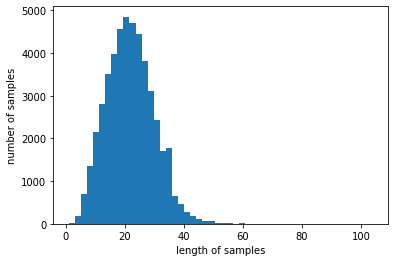

In [76]:
print(f'longest sentence len: {max(len(s) for s in sentences)}')
print(f'mean sentence len: {sum(map(len, sentences))/len(sentences)}')
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- keras tokenizer 를 활용한 정수 인코딩

In [77]:
# 모든 단어 사용, idx[1] = OOV
src_tokenizer = Tokenizer(oov_token="OOV")
src_tokenizer.fit_on_texts(sentences)
# tag 정보 대문자 유지
tar_tokenizer = Tokenizer(lower=False)
tar_tokenizer.fit_on_texts(ner_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print(f'word_vocab len : {vocab_size}\ntag_vocab len : {tag_size}')
print(f'idx of OOV : {src_tokenizer.word_index["OOV"]}')

word_vocab len : 31819
tag_vocab len : 18
idx of OOV : 1


- 정수 인코딩 진행

In [78]:
X_data = src_tokenizer.texts_to_sequences(sentences)
Y_data = tar_tokenizer.texts_to_sequences(ner_tags)

print(X_data[0])
print(Y_data[0])

[254, 6, 967, 16, 1795, 238, 468, 7, 523, 2, 129, 5, 61, 9, 571, 2, 833, 6, 186, 90, 22, 15, 56, 3]
[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1]


- 모델 훈련 후, 결과 확인을 위한 변수 지정
  - index_to_word : 인덱스로부터 단어 리턴
  - index_to_ner : 인덱스로부터 tag 리턴

In [79]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word

ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = "PAD"

index_to_ner

{0: 'PAD',
 1: 'O',
 2: 'B-geo',
 3: 'B-tim',
 4: 'B-org',
 5: 'I-per',
 6: 'B-per',
 7: 'I-org',
 8: 'B-gpe',
 9: 'I-geo',
 10: 'I-tim',
 11: 'B-art',
 12: 'B-eve',
 13: 'I-art',
 14: 'I-eve',
 15: 'B-nat',
 16: 'I-gpe',
 17: 'I-nat'}

## 3) 문자 임베딩을 위한 preprocessing

- 문자와 매핑된 정수를 각각 임베딩 층을 거치도록 하여, 문자 단위의 임베딩을 얻어낸다
  - 전체 데이터의 모든 단어를 문자 레벨로 분해 -> 문자 집합 생성

In [80]:
words = list(set(data['Word'].values))
chars = set([char for word in words for char in word])
chars = sorted(list(chars))
print('char set elements')
print('-'*50)
for i in range(len(chars)//9):
  print(chars[i*9:i*9+9])

char set elements
--------------------------------------------------
['!', '"', '#', '$', '%', '&', "'", '(', ')']
['+', ',', '-', '.', '/', '0', '1', '2', '3']
['4', '5', '6', '7', '8', '9', ':', ';', '?']
['@', '[', ']', '_', '`', 'a', 'b', 'c', 'd']
['e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
['n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v']
['w', 'x', 'y', 'z', '~', '\x85', '\x91', '\x92', '\x93']
['\x94', '\x96', '\x97', '\xa0', '°', 'é', 'ë', 'ö', 'ü']


- 딕셔너리 생성
  - char to index
  - index to char

In [81]:
char_to_idx = {val : idx+2 for idx,val in enumerate(chars)}
char_to_idx["OOV"] = 1
char_to_idx["PAD"] = 0

idx_to_char = {}
for k,v in char_to_idx.items():
  idx_to_char[v] = k

- 문자의 최대 길이를 15로 제한한 후, 그 미만의 문장 패딩 추가
  - post padding 하는 이유?

In [82]:
max_len_sentence = 15

def padding_char_indice(char_indice:list, max_len_sentence:int):
  return pad_sequences(char_indice, maxlen=max_len_sentence, padding='post', value=0)

# word to sequence and padding
def integer_coding(sentences):
  char_data = []
  for sentence in sentences:
    word_indice = [word_to_index[word] for word in sentence]
    char_indice = [[char_to_idx[char] for char in word] for word in sentence]
    char_indice = padding_char_indice(char_indice, max_len_sentence)

    for char_token in char_indice:
      if len(char_token) > max_len_sentence:
        continue
    char_data.append(char_indice)
  return char_data

X_char_data = integer_coding(sentences)

In [83]:
print('before\tafter')
for bef, af in zip(sentences[0], X_data[0]):
  print(f'{bef}\t{af}')

before	after
thousands	254
of	6
demonstrators	967
have	16
marched	1795
through	238
london	468
to	7
protest	523
the	2
war	129
in	5
iraq	61
and	9
demand	571
the	2
withdrawal	833
of	6
british	186
troops	90
from	22
that	15
country	56
.	3


In [87]:
print(f'len of X_char_data[0]\'s col len:{len(X_char_data[0][0])}')
print(X_char_data[0])

len of X_char_data[0]'s col len:15
[[53 41 48 54 52 34 47 37 52  0  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 48 47 52 53 51 34 53 48 51 52  0  0]
 [41 34 55 38  0  0  0  0  0  0  0  0  0  0  0]
 [46 34 51 36 41 38 37  0  0  0  0  0  0  0  0]
 [53 41 51 48 54 40 41  0  0  0  0  0  0  0  0]
 [45 48 47 37 48 47  0  0  0  0  0  0  0  0  0]
 [53 48  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [49 51 48 53 38 52 53  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 34 51  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 47  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [42 51 34 50  0  0  0  0  0  0  0  0  0  0  0]
 [34 47 37  0  0  0  0  0  0  0  0  0  0  0  0]
 [37 38 46 34 47 37  0  0  0  0  0  0  0  0  0]
 [53 41 38  0  0  0  0  0  0  0  0  0  0  0  0]
 [56 42 53 41 37 51 34 56 34 45  0  0  0  0  0]
 [48 39  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [35 51 42 53 42 52 41  0  0  0  0  0  0  0  0]
 [53 51 48 48 49 52  0  0  0  0  0  0  0  0  0]
 [39 

## 4) Data split

- max_len(70) 만큼 패딩 진행 및 train/test set 분리

In [20]:
max_len = 70
# padding to sequence
X_data = pad_sequences(X_data, maxlen=max_len, padding='post', value=0)
Y_data = pad_sequences(Y_data, maxlen=max_len, padding='post', value=0)
X_char_data = pad_sequences(X_char_data, maxlen=max_len, padding='post', value=0)

In [21]:
#split train/test data
X_train, X_test, Y_train_int, Y_test_int = train_test_split(X_data, Y_data, test_size=.2, random_state=777)
X_char_train, X_char_test, _, _ = train_test_split(X_char_data, Y_data, test_size=.2, random_state=777)

X_char_train = np.array(X_char_train)
X_char_test = np.array(X_char_test)

In [22]:
#one-hot encoding to tag info
Y_train = to_categorical(Y_train_int, num_classes=tag_size)
Y_test = to_categorical(Y_test_int, num_classes=tag_size)

In [23]:
print(f'first word of sentence\' 150th : {index_to_word[150]}')

for col in X_char_train[0]:
  for idx in col:
    if idx != 0:
      print(idx_to_char[idx], end='')
  print(end=' ')

first word of sentence' 150th : soldiers
soldiers returned fire with artillery and machine guns and a gun battle broke out .                                                        

- 각 데이터와 레이블의 크기 확인

In [24]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(Y_train.shape))
print('훈련 샘플 char 데이터의 크기 : {}'.format(X_char_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(Y_test.shape))

훈련 샘플 문장의 크기 : (38367, 70)
훈련 샘플 레이블의 크기 : (38367, 70, 18)
훈련 샘플 char 데이터의 크기 : (38367, 70, 15)
테스트 샘플 문장의 크기 : (9592, 70)
테스트 샘플 레이블의 크기 : (9592, 70, 18)


# 2. BiLSTM-CNN을 이용한 개체명 인식
## import lib

In [25]:
!pip install seqeval
!pip install keras-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.5 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=fa48c1a13279f6f3804d31df5aede232def66191ff82500e24a595b6cfc129af
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.9 MB/s 


In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, TimeDistributed, Dropout, concatenate, Bidirectional, LSTM, Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from seqeval.metrics import f1_score, classification_report
from keras_crf import CRFModel

## define fields & models

In [88]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size =3

- 단어 임베딩

In [89]:
word_ids = Input(shape=(None,), dtype='int32', name='words_input')
word_embeddings = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(word_ids)

- char embedding

In [90]:
char_ids = Input(shape=(None, max_len_sentence,), name='char_input')
embed_char_out = TimeDistributed(
    Embedding(len(char_to_idx), char_embedding_dim, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), 
    name='char_embedding')(char_ids)
dropout = Dropout(dropout_ratio)(embed_char_out)

- char embedding 에 Conv1D 수행

In [97]:
conv1d_out = TimeDistributed(
    Conv1D(
        kernel_size=kernel_size,
        filters=num_filters,
        padding='same',
        activation='tanh',
        strides=1),
        name='Conv1D')(dropout)

maxpool_out = TimeDistributed(
    MaxPooling1D(max_len_sentence),
    name='MaxPool1D'
)(conv1d_out)

char_embeddings = TimeDistributed(Flatten(), name='Flatten')(maxpool_out)
char_embeddings = Dropout(dropout_ratio)(char_embeddings)

- char embedding 에 conv1d 수행한 결과를 단어 임베딩과 concatenate

In [98]:
output = concatenate([word_embeddings, char_embeddings])

- 연결된 output 백터를 문장의 길이만큼 BiLSTM 만들기

In [99]:
output = Bidirectional(
    LSTM(
        hidden_units,
         return_sequences=True,
         dropout=dropout_ratio
    )
)(output)

- 출력층

In [103]:
output = TimeDistributed(
    Dense(
        tag_size,
        activation='softmax',

    ),
    name='Dense'
)(output)

In [104]:
model = Model(
    inputs = [word_ids, char_ids],
    outputs=[output]
)
model.compile(
    loss='categorical_crossentropy',
    optimizer='nadam',
    metrics=['acc']
)

In [105]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, None, 15)]   0           []                               
                                                                                                  
 char_embedding (TimeDistribute  (None, None, 15, 64  4736       ['char_input[0][0]']             
 d)                             )                                                                 
                                                                                                  
 dropout_6 (Dropout)            (None, None, 15, 64  0           ['char_embedding[0][0]']         
                                )                                                                 
                                                                                            

## train model(weight file 있는 경우 실행할 필요 없음)
- early stopping callback 설정


In [44]:
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=4
)

mc = ModelCheckpoint(
    'bilstm_cnn.h5',
    monitor='val_acc',
    mode='max',
    verbose=1,
    save_best_only=True
)

# batch_size= 128, epoch=15, val_data_ratio = 10%
history = model.fit(
    [X_train, X_char_train], Y_train,
    batch_size=128, epochs=15, validation_split=0.1,
    verbose=1, callbacks=[es,mc]
)

Epoch 1/15
270/270 [==============================] - ETA: 0s - loss: 0.2063 - acc: 0.9474
Epoch 1: val_acc improved from -inf to 0.97518, saving model to bilstm_cnn.h5
270/270 [==============================] - 526s 2s/step - loss: 0.2063 - acc: 0.9474 - val_loss: 0.0881 - val_acc: 0.9752
Epoch 2/15
270/270 [==============================] - ETA: 0s - loss: 0.0650 - acc: 0.9815
Epoch 2: val_acc improved from 0.97518 to 0.98367, saving model to bilstm_cnn.h5
270/270 [==============================] - 427s 2s/step - loss: 0.0650 - acc: 0.9815 - val_loss: 0.0549 - val_acc: 0.9837
Epoch 3/15
270/270 [==============================] - ETA: 0s - loss: 0.0461 - acc: 0.9865
Epoch 3: val_acc improved from 0.98367 to 0.98624, saving model to bilstm_cnn.h5
270/270 [==============================] - 439s 2s/step - loss: 0.0461 - acc: 0.9865 - val_loss: 0.0458 - val_acc: 0.9862
Epoch 4/15
270/270 [==============================] - ETA: 0s - loss: 0.0385 - acc: 0.9885
Epoch 4: val_acc improved from

## get results
- validation data 에 대해 정확도가 가장 높았던 모델 테스트

In [35]:
#load model
model = load_model('bilstm_cnn.h5')

# test data index
i = 13
y_predicted = model.predict([np.array([X_test[i]]), np.array([X_char_test[i]])])

# 확률 벡터 -> 정수값으로 변경
y_predicted = np.argmax(y_predicted, axis=-1)
labels = np.argmax(Y_test[i], -1)

print(f'단어\t\t실제값\t예측값')
print('-'*50)

for word, tag, pred in zip(X_test[i], labels, y_predicted[0]):
  # word = 'PAD' 인 경우 제외
  if word !=0:
    print(f'{index_to_word[word]:17}:\t{index_to_ner[tag]}\t{index_to_ner[pred]}')

단어		실제값	예측값
--------------------------------------------------
the              :	O	O
statement        :	O	O
came             :	O	O
as               :	O	O
u.n.             :	B-org	B-org
secretary-general:	I-org	I-org
kofi             :	B-per	B-per
annan            :	I-per	I-per
met              :	O	O
with             :	O	O
officials        :	O	O
in               :	O	O
amman            :	B-geo	B-geo
to               :	O	O
discuss          :	O	O
wednesday        :	B-tim	B-tim
's               :	O	O
attacks          :	O	O
.                :	O	O


- 테스트 데이터(test set)에 대해 성능 측정

In [36]:
def sequences_to_tag(sequences):
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences:
        word_sequence = []
        # 시퀀스로부터 확률 벡터 또는 원-핫 벡터를 하나씩 꺼낸다.
        for pred in sequence:
            # 정수로 변환. 예를 들어 pred가 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
            pred_index = np.argmax(pred)            
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

In [37]:
y_predicted = model.predict([X_test, X_char_test])
pred_tags = sequences_to_tag(y_predicted)
test_tags = sequences_to_tag(Y_test)

print(f'f1-score : {f1_score(test_tags, pred_tags):.1%}')
print(classification_report(test_tags, pred_tags))

f1-score : 79.2%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.44      0.27      0.33        52
         geo       0.84      0.85      0.84      7620
         gpe       0.95      0.95      0.95      3145
         nat       0.47      0.19      0.27        37
         org       0.60      0.57      0.58      4033
         per       0.74      0.72      0.73      3545
         tim       0.86      0.84      0.85      4067

   micro avg       0.80      0.78      0.79     22562
   macro avg       0.61      0.55      0.57     22562
weighted avg       0.80      0.78      0.79     22562



# 3. BiLSTM-CNN-CRF

- CRF 층을 추가한 모델과 문자 임베딩을 모두 활용한 모델의 성능 파악

## define fields & model

### fields

In [39]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.5
hidden_units = 256
num_filters = 30
kernel_size = 3

- 단어 임베딩

In [40]:
word_ids = Input(shape=(None,), dtype='int32', name='words_input')
word_embeddings = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim)(word_ids)

- 캐릭터 임베딩

In [43]:
char_ids = Input(
    shape=(None, max_len_sentence),
    name = 'char_input'
)
embed_char_out = TimeDistributed(
    Embedding(
        len(char_to_idx),
        char_embedding_dim,
        embeddings_initializer=RandomUniform(
            minval=-0.5, maxval=0.5
        )
    ),
    name='char_embedding')(char_ids)
dropout = Dropout(dropout_ratio)(embed_char_out)

- Conv1D to char embedding

In [44]:
conv1d_out = TimeDistributed(
    Conv1D(
        kernel_size=kernel_size,
        filters=num_filters,
        padding='same',
        activation='tanh',
        strides=1))(dropout)
maxpool_out = TimeDistributed(
    MaxPooling1D(max_len_sentence))(conv1d_out)

char_embeddings = TimeDistributed(Flatten())(maxpool_out)
char_embeddings = Dropout(dropout_ratio)(char_embeddings)

output = concatenate([word_embeddings, char_embeddings])

- 연결한 벡터를 문장 길이만큼 BiLSTM 수행

In [45]:
output = Bidirectional(
    LSTM(
        hidden_units,
         return_sequences=True,
         dropout = dropout_ratio
    )
)(output)

- 출력층

In [46]:
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

### define model

In [47]:
base = Model(
    inputs=[word_ids, char_ids],
    outputs=[output]
)
model = CRFModel(base, tag_size)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics='accuracy'
)

es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=4
)
mc = ModelCheckpoint(
    'bilstm_cnn_crf/cp.ckpt',
    monitor='val_decode_sequence_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True,
    save_weights_only=True
)

### train model
- CRF layer 는 one-hot encoding 된 label 을 지원하지 않으므로 y_train_int 사용

In [48]:
#diff Y_train, Y_train_int
print(Y_train[0])
print(Y_train_int[0])

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [49]:
history = model.fit(
    [X_train, X_char_train], Y_train_int,
    batch_size= 128,
    epochs=15,
    validation_split=0.1,
    callbacks=[mc, es]
)

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9422 - loss: 17.5997
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.96929, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 563s 2s/step - decode_sequence_accuracy: 0.9422 - loss: 17.5631 - val_decode_sequence_accuracy: 0.9693 - val_loss: 7.5107
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9762 - loss: 5.3899
Epoch 2: val_decode_sequence_accuracy improved from 0.96929 to 0.97966, saving model to bilstm_cnn_crf/cp.ckpt
270/270 [==============================] - 476s 2s/step - decode_sequence_accuracy: 0.9762 - loss: 5.3842 - val_decode_sequence_accuracy: 0.9797 - val_loss: 4.7122
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9837 - loss: 3.3867
Epoch 3: val_decode_sequence_accuracy improved from 0.97966 to 0.98402, saving model to bilstm_cnn_crf/cp.ckpt
270/

### 결과 확인

- 가장 결과가 좋은 가중치 load, predict

In [54]:
model.load_weights('bilstm_cnn_crf/cp.ckpt')

i = 13
Y_predicted = model.predict(
    [np.array([X_test[i]]), np.array([X_char_test[i]])])[0]
labels = np.argmax(Y_test[i], -1)

In [56]:
print(f'단어\t\t실제값\t예측값')
print('-'*50)

for word, tag, pred in zip(X_test[i], labels, Y_predicted[0]):
  # PAD 제외
  if word != 0:
    print(f'{index_to_word[word]:19}{index_to_ner[tag]:7}{index_to_ner[pred]}')  

단어		실제값	예측값
--------------------------------------------------
the                O      O
statement          O      O
came               O      O
as                 O      O
u.n.               B-org  B-org
secretary-general  I-org  I-org
kofi               B-per  B-per
annan              I-per  I-per
met                O      O
with               O      O
officials          O      O
in                 O      O
amman              B-geo  B-geo
to                 O      O
discuss            O      O
wednesday          B-tim  B-tim
's                 O      O
attacks            O      O
.                  O      O


- 테스트 데이터 성능 측정

In [57]:
def sequences_to_tag_for_crf(sequences): 
    result = []
    # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
    for sequence in sequences: 
        word_sequence = []
        # 시퀀스로부터 예측 정수 레이블을 하나씩 꺼낸다.
        for pred_index in sequence:
            # index_to_ner을 사용하여 정수를 태깅 정보로 변환. 'PAD'는 'O'로 변경.
            word_sequence.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(word_sequence)
    return result

Y_predicted = model.predict(
    [X_test, X_char_test]
)[0]

pred_tags = sequences_to_tag_for_crf(Y_predicted)
test_tags = sequences_to_tag(Y_test)

print(f'f1-score : {f1_score(test_tags, pred_tags):.1%}')
print(classification_report(test_tags, pred_tags))

f1-score : 81.1%
              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.55      0.31      0.40        52
         geo       0.85      0.85      0.85      7620
         gpe       0.95      0.94      0.95      3145
         nat       1.00      0.08      0.15        37
         org       0.67      0.60      0.63      4033
         per       0.79      0.73      0.76      3545
         tim       0.87      0.85      0.86      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.71      0.55      0.57     22562
weighted avg       0.82      0.79      0.81     22562



# 4.BiLSTM-BiLSTM-CRF

In [60]:
embedding_dim = 128
char_embedding_dim = 64
dropout_ratio = 0.3
hidden_units = 64

# 단어 임베딩
word_ids = Input(batch_shape=(None, None), dtype='int32', name='word_input')
word_embeddings = Embedding(input_dim=vocab_size,
                                        output_dim=embedding_dim,
                                        name='word_embedding')(word_ids)

# char 임베딩
char_ids = Input(batch_shape=(None, None, None), dtype='int32', name='char_input')
char_embeddings = Embedding(input_dim=(len(char_to_idx)),
                                        output_dim=char_embedding_dim,
                                        embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5),
                                        name='char_embedding')(char_ids)

# char 임베딩을 BiLSTM을 통과 시켜 단어 벡터를 얻고 단어 임베딩과 연결
char_embeddings = TimeDistributed(Bidirectional(LSTM(hidden_units)))(char_embeddings)
output = concatenate([word_embeddings, char_embeddings])

# 연결한 벡터를 가지고 문장의 길이만큼 LSTM을 수행
output = Dropout(dropout_ratio)(output)
output = Bidirectional(LSTM(units=hidden_units, return_sequences=True))(output)

# 출력층
output = TimeDistributed(Dense(tag_size, activation='relu'))(output)

base = Model(inputs=[word_ids, char_ids], outputs=[output])
model = CRFModel(base, tag_size)
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('bilstm_bilstm_crf/cp.ckpt', monitor='val_decode_sequence_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)

history = model.fit([X_train, X_char_train], Y_train_int, batch_size=128, epochs=15, validation_split=0.1, callbacks=[mc, es])

Epoch 1/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9298 - loss: 22.1273
Epoch 1: val_decode_sequence_accuracy improved from -inf to 0.96477, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 651s 2s/step - decode_sequence_accuracy: 0.9298 - loss: 22.0729 - val_decode_sequence_accuracy: 0.9648 - val_loss: 7.6636
Epoch 2/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9783 - loss: 4.8422
Epoch 2: val_decode_sequence_accuracy improved from 0.96477 to 0.98380, saving model to bilstm_bilstm_crf/cp.ckpt
270/270 [==============================] - 635s 2s/step - decode_sequence_accuracy: 0.9783 - loss: 4.8368 - val_decode_sequence_accuracy: 0.9838 - val_loss: 3.4269
Epoch 3/15
270/270 [==============================] - ETA: 0s - decode_sequence_accuracy: 0.9860 - loss: 2.8967
Epoch 3: val_decode_sequence_accuracy improved from 0.98380 to 0.98555, saving model to bilstm_bilstm_crf/cp.

### model 검증


- load weight and sample test

In [64]:
model.load_weights('bilstm_bilstm_crf/cp.ckpt')

i = 13
Y_predicted = model.predict(
    [np.array([X_test[i]]), np.array([X_char_test[i]])]
)[0]
labels = np.argmax(Y_test[i], -1)

print(f'단어\t\t실제값\t예측값')
print('-'*50)

for word, tag, pred in zip(X_test[i], labels, Y_predicted[0]):
  # PAD 제외
  if word != 0:
    print(f'{index_to_word[word]:19}{index_to_ner[tag]:7}{index_to_ner[pred]}')  

단어		실제값	예측값
--------------------------------------------------
the                O      O
statement          O      O
came               O      O
as                 O      O
u.n.               B-org  B-org
secretary-general  I-org  I-org
kofi               B-per  B-per
annan              I-per  I-per
met                O      O
with               O      O
officials          O      O
in                 O      O
amman              B-geo  B-geo
to                 O      O
discuss            O      O
wednesday          B-tim  B-tim
's                 O      O
attacks            O      O
.                  O      O


- test data 성능 측정

In [65]:
Y_predicted = model.predict([X_test, X_char_test])[0]
pred_tags = sequences_to_tag_for_crf(Y_predicted)
test_tags = sequences_to_tag(Y_test)

print(f'f1-score : {f1_score(test_tags, pred_tags):.1%}')
print(classification_report(test_tags, pred_tags))

f1-score : 81.1%


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00        63
         eve       0.50      0.29      0.37        52
         geo       0.84      0.85      0.85      7620
         gpe       0.95      0.95      0.95      3145
         nat       0.33      0.08      0.13        37
         org       0.69      0.57      0.63      4033
         per       0.80      0.74      0.77      3545
         tim       0.89      0.83      0.86      4067

   micro avg       0.83      0.79      0.81     22562
   macro avg       0.62      0.54      0.57     22562
weighted avg       0.83      0.79      0.81     22562

